The goal of this notebook is to explore the potential of a model which attempts to classify whether or not a tornado will cause damage

## Set up

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import pylab
import math
pylab.rcParams['figure.figsize'] = (8.25, 6)
from sklearn.metrics import roc_curve, auc, confusion_matrix

Importing and formatting the training data

In [2]:
# Import the training data
tor_df = pd.read_csv("/home/jeremydiaz/tornadoesr/data/raw/tor_train_set.csv")


# Get the outcomes
tornado_outcome = tor_df.iloc[:, [2]]

# Convert the pandas column to a ndarray and then into a FloatTensor
outcome_Tensor = torch.from_numpy(tornado_outcome.values).float()


# Get the predictors
tornado_predictors = tor_df.iloc[:, 3:]

# Make the validation set predictors into a numpy array
predictors_Tensor = torch.from_numpy(tornado_predictors.values).float()

Now the cross-validation data

In [3]:
# Import cross-validation data
cv_df = pd.read_csv("/home/jeremydiaz/tornadoesr/data/raw/tor_cv_set.csv")


# Get the outcomes
cv_outcome = cv_df.iloc[:, [2]]

# Convert the pandas column to a ndarray and then into a FloatTensor
cv_outcome_Tensor = torch.from_numpy(cv_outcome.values).float()


# Get the validation set predictors
cv_predictors = cv_df.iloc[:, 3:]

# Make the validation set predictors into a numpy array
cv_predictors_Tensor = torch.from_numpy(cv_predictors.values).float()

Now the test set data

In [4]:
# Import the test set data
test_df = pd.read_csv("/home/jeremydiaz/tornadoesr/data/raw/tor_test_set.csv")


# Get the outcomes
test_outcome = test_df.iloc[:, [2]]

# Convert the pandas column to a ndarray and then into a FloatTensor
test_outcome_Tensor = torch.from_numpy(test_outcome.values).float()


# Get the test set predictors
test_predictors = test_df.iloc[:, 3:]

# Make the test set predictors into a numpy array
test_predictors_Tensor = torch.from_numpy(test_predictors.values).float()

### Convert property damage to binary variable: no damage or damage

In [5]:
def convert_prop_dam_to_binary(property_damage_values):
    
    # This function will convert continuous property damage values to binary values defining whether
        # or not a tornado caused any damage
    # property_damage_values = a PyTorch Tensor containing property damage values
    # Returns as PyTorch Tensor of binary values
    
    
    # Get the Tensor as a ndarray 
    prop_dam_array = property_damage_values.numpy()
    
    # For-loop to convert to binary
    for i in list(range(len(prop_dam_array))):
        
        if (prop_dam_array[i] == prop_dam_array.min())[0]:
            
            prop_dam_array[i] = 0
            
        else:
            
            prop_dam_array[i] = 1
     
    # Convert ndarray to Tensor
    prop_dam_Tensor = torch.from_numpy(prop_dam_array)
    
    # Return Tensor
    return(prop_dam_Tensor)

In [6]:
# Convert the training data
outcome_Tensor_binary = convert_prop_dam_to_binary(outcome_Tensor)

# And the cv data
cv_outcome_Tensor_binary = convert_prop_dam_to_binary(cv_outcome_Tensor)

# And the test data
test_outcome_Tensor_binary = convert_prop_dam_to_binary(test_outcome_Tensor)

## 1. Make the classifying neural network

This classifier will predict the probability that a tornado causes damage.

Define the model architecture

In [7]:
# Define the neural network
class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(51, 26)
        self.fc2 = torch.nn.Linear(26, 1)
        
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.sigmoid(self.fc2(x))
        return(x)


# Make it
classifier = Net()

Define the loss function

In [8]:
loss_fn = torch.nn.BCELoss(size_average = False)

Defining a function to setup and train the models. It will also produce a loss versus iteration plot

In [9]:
def train_model(model, train_outcomes, train_inputs,
                     cv_outcomes, cv_inputs):
    
    # This function will train the neural network and produce a loss versus iteration plot
    # model = the model architecture, a Net class
    # train_outcomes = the right answers, PyTorch Tensor
    # train_inputs = what we're using to get to the right answers, PyTorch Tensor
    # cv_outcomes = the right answers of the new data, PyTorch Tensor
    # cv_inputs = what we're using to get the new right answers, PyTorch Tensor
    # Returns a plot and a trained Net
    
    
    # Make the outcomes into a Torch Variable
    outcome_Variable = Variable(train_outcomes)
    
    # Make the cv outcomes into a Torch Variable
    cv_outcome_Variable = Variable(cv_outcomes,
                                   requires_grad = False)
    
    # Make the predictors into a Torch Variable
    predictors_Variable = Variable(train_inputs,
                                   requires_grad = False)
    
    # Make the cv predictors into a Torch Variable
    cv_predictors_Variable = Variable(cv_inputs,
                                      requires_grad = False)
    
    
    # Make an empty list to add to for each iteration
    current_loss_value_mini = []
    
    # For the cv too
    current_cv_loss_value = []
    
    
    # Set the optimizer
    optimizer = torch.optim.Adagrad(model.parameters(), lr = 1e-2)
    
    
    # Train the neural network
    for t in range(20000):
        
        # Get the current mini-batch indices
        indices = torch.randperm(len(train_outcomes))[0:50]
        
        # Get the current mini-batches
        predictors_mini = predictors_Variable[indices]
        outcome_mini = outcome_Variable[indices]
        
        # Get the current predictions
        current_pred_mini = model(predictors_mini)
        cv_pred = model(cv_predictors_Variable)
        
        # Compute current losses and and append that to the empty list
        current_loss_mini = loss_fn(current_pred_mini, outcome_mini)
        current_loss_value_mini.append(current_loss_mini.data[0])
        
        current_cv_loss = loss_fn(cv_pred, cv_outcome_Variable)
        current_cv_loss_value.append(current_cv_loss.data[0])
        
        # Zero the gradients before backwards pass
        optimizer.zero_grad()
        
        # Backwards pass
        current_loss_mini.backward()
        
        # Update model parameters
        optimizer.step()
    
    
    # Get iterations as a list for x-axis of plot
    iterations = list(range(0, 20000))
    
    
    # Convert total square error to mean square error
    mse = (np.asarray(current_loss_value_mini) / len(predictors_mini)).tolist()
    
    # For cv too
    mse_cv = (np.asarray(current_cv_loss_value) / len(cv_predictors_Variable)).tolist()
    
    
    # Plot loss versus iteration
    plt.plot(iterations, mse)
    plt.plot(iterations, mse_cv, "r-")
    plt.xlabel("Iteration", size = 14)
    plt.ylabel("Loss Value", size = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title("How'd the Optimizing Go?", size = 16)

Train the classifier.

The plot will display how well it optimized. The blue line is the mini batch values that the model was optimized on, while the red line is new (cross-validation) data.

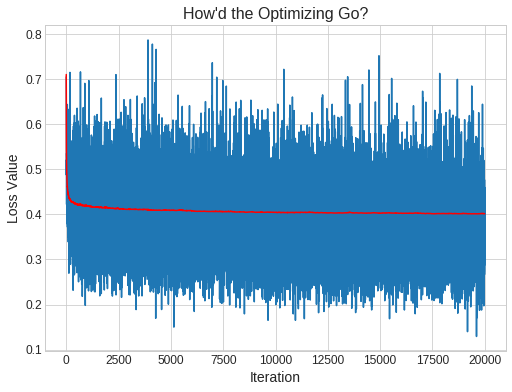

In [10]:
train_model(classifier, outcome_Tensor_binary, predictors_Tensor,
            cv_outcome_Tensor_binary, cv_predictors_Tensor)

How'd the model perform on the data used to make it?

In [11]:
def plot_perf(train_predictors, train_obs, model, alpha_val):
    
    # Plots how well the model performs on training data
    # train_predictors = the values that the model predicts from, PyTorch Tensor
    # train_obs = what the model would ideally predict, PyTorch Tensor
    # Returns a plot
    
    
    # Get the predictions
    train_predictions = model(Variable(train_predictors, requires_grad = False))
    
    # Convert that to a numpy array
    train_predictions = train_predictions.data.numpy()
    
    # Put it in log-transformed scale and convert it to a list
    train_predictions = train_predictions.tolist()
    
    
    # Put the observed outcomes in log-transformed scale
    # and convert it to a list
    train_obs = train_obs.numpy().tolist()
    
    
    # Plot it
    plt.scatter(train_obs, train_predictions, alpha = alpha_val, facecolor = 'k')
    axes = plt.gca()
    plt.xticks([0, 1], ['\nNon-damaging', '\nDamaging'], fontsize = 12)
    plt.xlim(-0.05, 1.05)
    plt.ylim(0, 1)
    axes.grid(False)
    axes.set_xlabel('True Outcome', size = 14)
    axes.set_ylabel('Predicted Probability of Damage', size = 14)
    plt.axhline(y = 0.5, color = 'r', linestyle = '--');

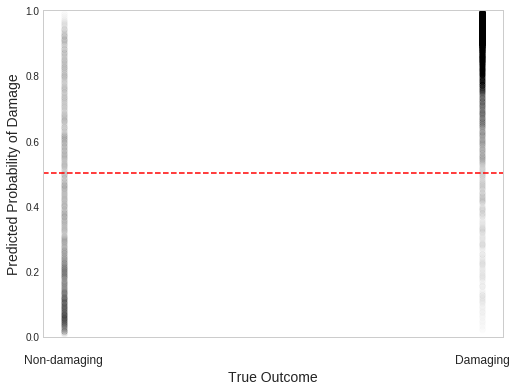

In [12]:
plot_perf(predictors_Tensor, outcome_Tensor_binary, classifier, 0.0025)

## 2. Accuracies

In [13]:
# Get predicted probabilities as binary values
classifier_pred = np.round(classifier(Variable(predictors_Tensor, requires_grad = False)).data.numpy())

# Determine if those predictions are right
number_correct_preds = (classifier_pred == outcome_Tensor_binary.numpy())

# Get the accuracy of those predictions
train_accuracy = (sum(number_correct_preds) / len(number_correct_preds))[0]


# Lets get it in words
'Training set accuracy is: ' + str(train_accuracy)

'Training set accuracy is: 0.837763593763'

In [14]:
cv_classifier_pred = np.round(classifier(Variable(cv_predictors_Tensor, requires_grad = False)).data.numpy())

number_correct_cv_preds = (cv_classifier_pred == cv_outcome_Tensor_binary.numpy())

cv_accuracy = (sum(number_correct_cv_preds) / len(number_correct_cv_preds))[0]


'Cross-validation set accuracy is: ' + str(cv_accuracy)

'Cross-validation set accuracy is: 0.817983519147'

In [15]:
test_classifier_pred = np.round(classifier(Variable(test_predictors_Tensor, requires_grad = False)).data.numpy())

number_correct_test_preds = (test_classifier_pred == test_outcome_Tensor_binary.numpy())

test_accuracy = (sum(number_correct_test_preds) / len(number_correct_test_preds))[0]


'Test set accuracy is: ' + str(test_accuracy)

'Test set accuracy is: 0.826951042172'

### Confusion matrix results

In [16]:
confusion_matrix(test_outcome_Tensor_binary.numpy(), test_classifier_pred)

array([[ 778,  490],
       [ 224, 2634]])

## 3. Area under ROC curve

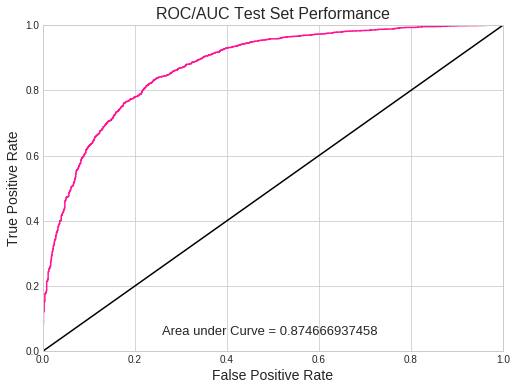

In [17]:
# Get the false positive and true positive rates using scikit-learn
fpr_a, tpr_a, _ = roc_curve(y_true = test_outcome_Tensor_binary.numpy(),
                            y_score = classifier(Variable(test_predictors_Tensor, requires_grad = False)).data.numpy())

# Calculate the area under the curve
area_under = auc(x = fpr_a,
                 y = tpr_a)


# Plot it all
plt.plot(fpr_a, tpr_a, 'deeppink')
plt.plot(fpr_a, fpr_a, 'black')
plt.xlabel('False Positive Rate', size = 14)
plt.ylabel('True Positive Rate', size = 14)
plt.title('ROC/AUC Test Set Performance', size = 16)
plt.text(0.26, 0.05, 'Area under Curve = %s'%(area_under), size = 13)
axes = plt.gca()
axes.set_xlim([0, 1])
axes.set_ylim([0, 1]);

We now have a neural network that outputs the probability that a tornado causes damage. By using a prediction threshold of 0.50 (if the model outputs a value greater than 0.50, then we predict that it will definitively cause damage), we achieve approximately 82% accuracy and an area under the ROC curve value of approximately 0.87 on test data.

Coupling this with the previous neural networks which predict the damage that a tornado causes given that it does cause damage, we can know produce weight averages / expected values.

### Test set performance visualization

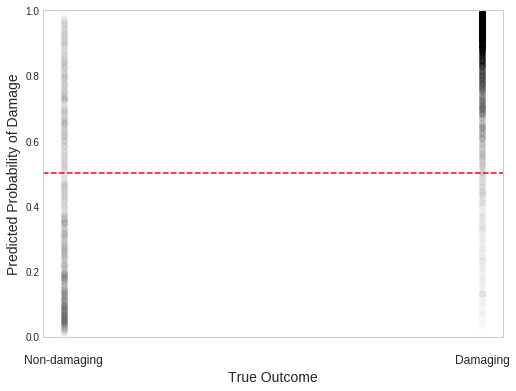

In [18]:
plot_perf(test_predictors_Tensor, test_outcome_Tensor_binary, classifier, 0.0075)